<a href="https://colab.research.google.com/github/johntzwei/metric-statistical-advantage/blob/main/human_comparison_wmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install sacrebleu
!pip install gdown

     |████████████████████████████████| 61kB 5.0MB/s 


In [ ]:
import pickle
import itertools
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import seaborn as sns
sns.set_context('paper', font_scale=0.73)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import matplotlib.pyplot as plt
import sacrebleu
import pdb

# Data

In [ ]:
!gdown --id 1RZg1GbRYvyXHCv4R3lzoEiVCgPC2e9TT

Downloading...
From: https://drive.google.com/uc?id=1RZg1GbRYvyXHCv4R3lzoEiVCgPC2e9TT
To: /content/wmt16-19_toen_scored.pkl
301MB [00:01, 152MB/s]


In [ ]:
wmt_scored = pickle.load(open('wmt16-19_toen_scored.pkl', 'rb'))
wmt_scored.head(1)

,lp,HITId,WorkerId,score,time,system,type,sid,reference,source,...,chrf:statistics_10,chrf:statistics_11,chrf:statistics_12,chrf:statistics_13,chrf:statistics_14,chrf:statistics_15,chrf:statistics_16,chrf:statistics_17,bert_score:f1,bleurt_score
0,de-en,3QQUBC64ZEEFIPT2SKINDZZTZ3SNXN,A0077,78,2052.0,online-G,SYSTEM,1906,Rather than having an executive make the annou...,Anstatt einen Manager die Ankündigung machen z...,...,151,95,145,150,85,144,149,76,0.941347,-0.00404


In [ ]:
# from variance_analysis_wmt.ipynb
pooled_vars = json.loads('{"wmt16": 307.17626731473774, "wmt17": 527.2973972404222, "wmt18": 382.8504227475613, "wmt19": 458.6292985991144}')
total_vars = json.loads('{"wmt16": 900.3456733124744, "wmt17": 879.1690392974084, "wmt18": 795.9652837204678, "wmt19": 829.785268929387}')

# Human comparisons

In [ ]:
ratios = {}
ratios[2016] = total_vars['wmt16'] / (total_vars['wmt16'] - pooled_vars['wmt16'])
ratios[2017] = total_vars['wmt17'] / (total_vars['wmt17'] - pooled_vars['wmt17'])
ratios[2018] = total_vars['wmt18'] / (total_vars['wmt18'] - pooled_vars['wmt18'])
ratios[2019] = total_vars['wmt19'] / (total_vars['wmt19'] - pooled_vars['wmt19'])

ratios

{2016: 1.5178558843540724,
 2017: 2.49855042071002,
 2018: 1.9267408629307818,
 2019: 2.2356780848520468}

In [ ]:
# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_noise_decomposition(metric_results, human_results, no_bias=False):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    optimal_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=human_results)
    
    if no_bias:
        main_predictions = optimal_predictions
    
    avg_expected_loss = (human_results != metric_results).mean()

    noises = (human_results != optimal_predictions).mean(axis=0)
    probs = (metric_results == optimal_predictions).mean(axis=0)

    avg_noise_contrib = ((2 * probs - 1) * noises).mean()

    avg_bias_contrib = (main_predictions != optimal_predictions).mean()

    signs = (main_predictions == optimal_predictions).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias_contrib, avg_var_contrib, avg_noise_contrib

In [ ]:
def pairs(x):
    for (year, lp), group in x.groupby(['year', 'lp']):
        systems = group.system.unique()
        
        for i, j in itertools.combinations(systems, 2):
            yield (year, lp), i, j
            
all_pairs = list(pairs(wmt_scored))
pairs_2019 = list(pairs(wmt_scored[wmt_scored.year == 2019]))

# all the pairwise predictions in the WMT dataset
# in the form of (year, language pair), system1, system2
all_pairs[:10]

[((2016, 'cs-en'), 'online-B', 'uedin-nmt'),
 ((2016, 'cs-en'), 'online-B', 'PJATK'),
 ((2016, 'cs-en'), 'online-B', 'online-A'),
 ((2016, 'cs-en'), 'online-B', 'jhu-pbmt'),
 ((2016, 'cs-en'), 'online-B', 'cu-mergedtrees'),
 ((2016, 'cs-en'), 'uedin-nmt', 'PJATK'),
 ((2016, 'cs-en'), 'uedin-nmt', 'online-A'),
 ((2016, 'cs-en'), 'uedin-nmt', 'jhu-pbmt'),
 ((2016, 'cs-en'), 'uedin-nmt', 'cu-mergedtrees'),
 ((2016, 'cs-en'), 'PJATK', 'online-A')]

In [ ]:
# get pairwise predictions from the scoring of each system
# in the form of a (num_pairs,) length vector, where 1 or 0 denotes the ordering of that pair
def get_preds(pairs, scores):
    preds = np.zeros(len(pairs))
    if type(scores) == type({}):
        for ii, ((year, lp), i, j) in enumerate(pairs):
            preds[ii] = 1 if scores[year, lp, i] - scores[year, lp, j] > 0 else 0
    else:
        for ii, ((year, lp), i, j) in enumerate(pairs):
            preds[ii] = 1 if scores.loc[year, lp, i] - scores.loc[year, lp, j] > 0 else 0
            
    return preds

In [ ]:
groupby_cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
groupby_labels = [ i[0] for i in groupby_cached ]

### Experimental parameters

In [ ]:
NUM_WORKERS = 12
NUM_TRIALS = 10000
CHUNKSIZE = 10
METRICS = range(100, 701, 100)

In [ ]:
SEED = 0
random_state = np.random.RandomState(SEED)

### Bootstrap experiments

In [ ]:
def f(x):
    n, ratios, seed = x
    this_rs = np.random.RandomState(seed)
    
    groups = [ g.sample(frac=1, replace=True, random_state=this_rs) for i, g in groupby_cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    observed_means = { label:mean for label, mean in zip(groupby_labels, observed_means) }
    
    # humans
    groups = [ g.sample(n=n, replace=True, random_state=this_rs) for i, g in groupby_cached ]
    human_means = [ g['score'].mean() for g in groups ]
    human_means = { label:mean for label, mean in zip(groupby_labels, human_means) }

    # theoretical
    groups = [ g.sample(n=int(n*ratios[i[0]]), replace=True, random_state=this_rs) for i, g in groupby_cached ]
    pa_means = [ g['score'].mean() for g in groups ]
    pa_means = { label:mean for label, mean in zip(groupby_labels, pa_means) }

    return get_preds(all_pairs, observed_means), get_preds(all_pairs, human_means), get_preds(all_pairs, pa_means)

results = {}
with Pool(NUM_WORKERS) as p:
    for metric in tqdm(METRICS):
        it = tqdm(p.imap_unordered(f, [(metric, ratios, random_state.randint(0, 2**32 - 1)) for i in range(0, NUM_TRIALS)],
                                   chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)

        label_results = np.array([ i[0] for i in output ], dtype=np.int64)
        human_results = np.array([ i[1] for i in output ], dtype=np.int64)
        pa_results = np.array([ i[2] for i in output ], dtype=np.int64)
        
        results[metric] = (bias_var_noise_decomposition(human_results, label_results, no_bias=True),
                          bias_var_noise_decomposition(pa_results, label_results, no_bias=True))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Results

In [ ]:
# from bvd_wmt.ipynb
bvd_results = json.loads('{"true_preds": [0.04662092145015106, 0.0, 0.04662092145015106, 0.0], "human": [0.06517129909365559, 0.0, 0.04655611782477341, 0.018614978731117823], "bleurt": [0.1283695550351288, 0.10772833723653395, 0.016108665105386416, 0.004564333302107728], "bert_score": [0.10236465256797583, 0.08610271903323263, 0.013156495468277945, 0.003103892386706949], "bleu": [0.14132953172205437, 0.1268882175226586, 0.006915634441087613, 0.007546726676737158], "ter": [0.1840821752265861, 0.1729607250755287, 0.00864237160120846, 0.0025213024773413904], "chrf": [0.12387673716012085, 0.10498489425981873, 0.009377794561933534, 0.009491543821752265]}')

### Graph

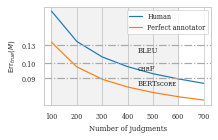

In [ ]:
x = list(range(100, 701, 100))
y = [results[i][0][2] for i in x]
y_pa = [results[i][1][2] for i in x]

plt.figure(figsize=(3, 1.8))
ax = sns.lineplot(x=x, y=y, label='Human')
sns.lineplot(x=x, y=y_pa, label='Perfect annotator')
ax.set(xlabel='Number of judgments', ylabel='$\\mathrm{Err}_{true}(M)$')
ax.yaxis.grid(False)
ax.legend(loc='upper right')

names = {
    'bleu' : 'BLEU',
    'chrf' : 'ᴄʜʀF',
    'bert_score' : 'BERTsᴄᴏʀᴇ'
}

biases = []
for metric, (err, bias, noise, var) in bvd_results.items():
    if metric in ['true_preds', 'human', 'ter', 'bleurt']:
        continue
    ax.axhline(bias, color='darkgrey', linestyle='-.')
    
    metric = names[metric]
    
    ax.annotate(metric, (440, bias-0.009), fontvariant='small-caps')
    biases.append(bias)
plt.yticks(biases, ['%.2f' % i for i in biases])
    
plt.axvspan(100, 600, color='grey', alpha=0.1)
plt.savefig('human_comparison_wmt.pdf', bbox_inches='tight')